<a href="https://www.kaggle.com/code/omarkhaled28/cifar-10-cnn-model?scriptVersionId=139984056" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
!pip install -U efficientnet
import albumentations as albu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf  
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import cv2
import keras
import efficientnet.keras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from skimage.transform import resize
from keras.utils import to_categorical
import albumentations as albu

# Data Loading

In [3]:
# Load the dataset from tensorflow
cifar100 = tf.keras.datasets.cifar10

# Split dataset into train and test sets
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


# Normalize the values in the images to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

170498071/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


# Data Visualization

In [4]:
# one-hot encoding

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


# Data Augmentation

In [5]:
#resizing the images as per EfficientNetB0 to size (224, 224)
height = 224
width = 224
channels = 3

n_classes = 10
input_shape = (height, width, channels)

epochs = 10
batch_size = 8

In [6]:
# function to resize image
def resize_img(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

In [7]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, images, labels = None, mode = 'fit', batch_size = batch_size, dim = (height, width), channels = channels, n_classes = n_classes, shuffle = True, augment = False):
        
        #initializing the configuration of the generator
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
   
    #method to be called after every epoch
    def on_epoch_end(self):
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    #return numbers of steps in an epoch using samples and batch size
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    #this method is called with the batch number as an argument to obtain a given batch of data
    def __getitem__(self, index):
        #generate one batch of data
        #generate indexes of batch
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        
        #generate mini-batch of X
        X = np.empty((self.batch_size, *self.dim, self.channels))
        
        for i, ID in enumerate(batch_indexes):
            #generate pre-processed image
            img = self.images[ID]
            #image rescaling
            img = img.astype(np.float32)/255.
            #resizing as per new dimensions
            img = resize_img(img, self.dim)
            X[i] = img
            
        #generate mini-batch of y
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            
            #augmentation on the training dataset
            if self.augment == True:
                X = self.__augment_batch(X)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            
    #augmentation for one image
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                   albu.VerticalFlip(p = 0.5),
                                   albu.GridDistortion(p = 0.2),
                                   albu.ElasticTransform(p = 0.2)])
        return composition(image = img)['image']
    
    #augmentation for batch of images
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch

In [8]:
train_data_generator = DataGenerator(x_train, y_train, augment = True)
valid_data_generator = DataGenerator(x_test, y_test, augment = False)

# Model Architecture

In [9]:
efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = input_shape, classes = n_classes)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation = 'sigmoid'))

model.summary()

16804768/16804768 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 4,020,358
Non-trainable params: 42,016
__________________________________________

# Model Training

In [10]:
# Compiling the model
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Setting up early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
filepath = "weights.h5"
rlrop = ReduceLROnPlateau(monitor ='val_loss', mode = 'min', patience = 5, factor = 0.5, min_lr = 1e-6, verbose = 1)
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True, monitor='val_accuracy')
callbacks_list = [checkpoint, es, rlrop]

In [12]:
# Model training
history = model.fit(train_data_generator,
                            validation_data = valid_data_generator,
                            callbacks = callbacks_list,
                            verbose = 1,
                            epochs = epochs)

Epoch 1/10


2023-08-15 12:16:16.737207: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6250/6250 [==============================] - ETA: 0s - loss: 0.7569 - accuracy: 0.7426
Epoch 1: val_accuracy improved from -inf to 0.93270, saving model to weights.h5
6250/6250 [==============================] - 879s 133ms/step - loss: 0.7569 - accuracy: 0.7426 - val_loss: 0.2067 - val_accuracy: 0.9327 - lr: 1.0000e-04
Epoch 2/10
6250/6250 [==============================] - ETA: 0s - loss: 0.4350 - accuracy: 0.8521
Epoch 2: val_accuracy improved from 0.93270 to 0.93940, saving model to weights.h5
6250/6250 [==============================] - 843s 135ms/step - loss: 0.4350 - accuracy: 0.8521 - val_loss: 0.1808 - val_accuracy: 0.9394 - lr: 1.0000e-04
Epoch 3/10
6250/6250 [==============================] - ETA: 0s - loss: 0.3394 - accuracy: 0.8844
Epoch 3: val_accuracy improved from 0.93940 to 0.94730, saving model to weights.h5
6250/6250 [==============================] - 853s 137ms/step - loss: 0.3394 - accuracy: 0.8844 - val_loss: 0.1660 - val_accuracy: 0.9473 - lr: 1.0000e-04
Epoch 4/1

# Model Saving

In [13]:
model.save('model.h5')

# Results Visualization

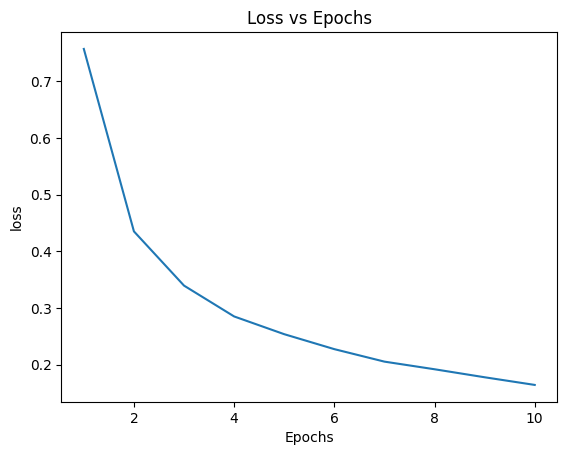

In [14]:
#Plotting loss vs epochs

plt.title('Loss vs Epochs')
plt.plot(list(range(1, len(history.history['loss'])+1)),history.history['loss'], label='loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

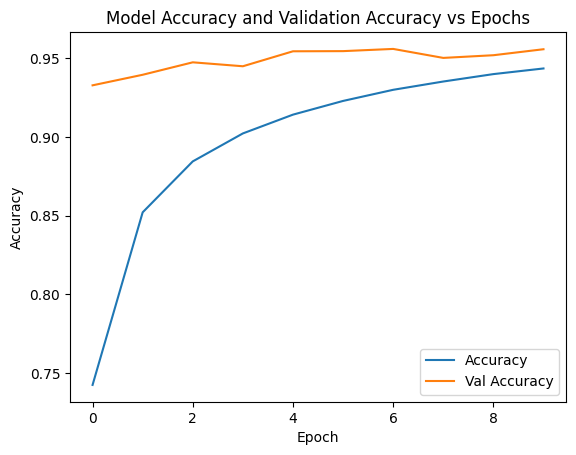

In [15]:
#Plotting model accuracy and validation accuracy vs epochs

plt.title('Model Accuracy and Validation Accuracy vs Epochs')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [16]:
valid_loss, valid_accuracy = model.evaluate(valid_data_generator, verbose = 0)

print('Model Accuracy: ', round((valid_accuracy * 100), 2), "%")

Model Accuracy:  95.56 %


In [17]:
# Test inference time
x = x_test[0]
x = resize_img(x, (224, 224))
x = np.expand_dims(x, axis=0)

start = time.time()
outputs = model(x, training=False)
end = time.time()
print(f'Inference Time: {end - start} Secs')

Inference Time: 0.16608548164367676 Secs


# Saving Results

In [18]:
preds = model.predict(DataGenerator(x_test, mode = 'predict', augment = False, shuffle = False), verbose = 1)
with open('Preds.csv', 'w', encoding='utf-8', newline='') as out:
    writer = csv.writer(out)
    writer.writerow(["ID","Label"])
    for i in range(len(x_test)):
        writer.writerow([i,np.argmax(preds[i])])

1250/1250 [==============================] - 21s 15ms/step
